# Install and Import libs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyvi

     |████████████████████████████████| 8.5 MB 4.6 MB/s 
     |████████████████████████████████| 743 kB 36.1 MB/s 


In [ ]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils.np_utils import to_categorical
%matplotlib inline

### Concat with external data source (AIVIVN)

In [ ]:
import re
import pandas as pd


correct_mapping = {
    "ship": "vận chuyển",
    "shop": "cửa hàng",
    "m": "mình",
    "mik": "mình",
    "ko": "không",
    "k": " không ",
    "kh": "không",
    "khong": "không",
    "kg": "không",
    "khg": "không",
    "tl": "trả lời",
    "r": "rồi",
    "fb": "mạng xã hội", # facebook
    "face": "mạng xã hội",
    "thanks": "cảm ơn",
    "thank": "cảm ơn",
    "tks": "cảm ơn",
    "tk": "cảm ơn",
    "ok": "tốt",
    "dc": "được",
    "vs": "với",
    "đt": "điện thoại",
    "thjk": "thích",
    "qá": "quá",
    "trể": "trễ",
    "bgjo": "bao giờ"
}


def tokmap(tok):
    if tok.lower() in correct_mapping:
        return correct_mapping[tok.lower()]
    else:
        return tok


def preprocess(review):
    tokens = review.split()
    tokens = map(tokmap, tokens)
    return " ".join(tokens)


def load_data(filepath, is_train=True):
    regex = 'train_'
    if not is_train:
        regex = 'test_'

    a = []
    b = []

    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if regex in line:
                b.append(a)
                a = [line]
            elif line != "":
                a.append(line)

        b.append(a)

    b = b[1:]
    lst = []
    for tp in b:
        idx = tp[0]
        if is_train:
            lb = int(tp.pop(-1))
        else:
            lb = "0"
        review = " ".join(tp[1:])
        review = re.sub(r"^\"*", "", review)
        review = re.sub(r"\"*$", "", review)
        review_ = preprocess(review)
        lst.append([idx, review, review_, lb])
    return lst


TRAIN_FILE = "./train.crash.txt"
TRAIN_CSV = "./train_augment.csv"
train_data = load_data(TRAIN_FILE)
print("# Loaded training samples: {}".format(len(train_data)))

cols = ["id", "text", "text_ws", "label"]
df_train = pd.DataFrame(data=train_data, columns=cols)

df_train = df_train[['label', 'text_ws']]
df_train.rename({'label': 'Class', 'text_ws': 'Data'}, axis=1, inplace=True)
df_train['Class'] = df_train['Class'].map({0: 1, 1: -1})
df_train.to_csv(TRAIN_CSV, index=False)

#  Load Train and test data

In [ ]:
def read_train_data():
  data_train = pd.read_csv("/content/drive/MyDrive/sentiment-analysis/vlsp_sentiment_train (1).csv", sep='\t')
  data_train.columns =['Class', 'Data']

  # thêm data
  data_aug = pd.read_csv('/content/drive/MyDrive/sentiment-analysis/train_augment.csv')
  data_train = pd.concat((data_train, data_aug))

  data_test = pd.read_csv("/content/drive/MyDrive/sentiment-analysis/vlsp_sentiment_test.csv", sep='\t')
  data_test.columns =['Class', 'Data'] 
  return data_train, data_test

data_train, data_test = read_train_data()


In [ ]:
print(data_train.shape)
print(data_test.shape)

(21187, 2)
(1050, 2)


# Preprocess data

In [ ]:
labels = data_train.iloc[:, 0].values
reviews = data_train.iloc[:, 1].values

In [ ]:
def encode_labels(labels):
  result = []
  for label in labels:
      if label == -1:
          result.append([1,0,0])
      elif label == 0:
          result.append([0,1,0])
      else:
          result.append([0,0,1])

  return np.array(result)  

encoded_labels = encode_labels(labels)

In [ ]:
reviews_processed = []
unlabeled_processed = [] 

def remove_digits(reviews_input):
  result=[]
  for review in reviews_input:
      review_cool_one = ''.join([char for char in review if char not in digits])
      result.append(review_cool_one)
  return result

reviews_processed = remove_digits(reviews)
unlabeled_processed = [] 

In [ ]:
#Use PyVi for Vietnamese word tokenizer

def tokenize(reviews_processed_input):
  result = []
  for review in reviews_processed_input:
      review = ViTokenizer.tokenize(review.lower())
      result.append(review.split())
  return result

word_reviews = tokenize(reviews_processed)
all_words = []
   

In [ ]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 100 # max number of words in a comment to use

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index


In [ ]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [ ]:
print('Shape of X train and X validation tensor:',data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (21187, 100)
Shape of label train and validation tensor: (21187, 3)


# Build and train model

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Embedding

def build_embedding_layer(word_index):

  word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/sentiment-analysis/vi-model-CBOW.bin', binary=True)
  
  vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
  embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
  for word, i in word_index.items():
      if i>=MAX_VOCAB_SIZE:
          continue
      try:
          embedding_vector = word_vectors[word]
          embedding_matrix[i] = embedding_vector
      except KeyError:
          embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

  del(word_vectors)


  return Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
  


embedding_layer = build_embedding_layer(word_index)

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional, LSTM, Permute, Attention, GlobalAveragePooling1D
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, Concatenate, Reshape, ReLU, BatchNormalization
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
from keras.metrics import Precision
from keras.metrics import Recall



def build_model(sequence_length, embedding_layer_input): 
  drop = 0.25
  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer_input(inputs)

  # Use Bidirectional LSTM
  bilstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)

  # BiLSTM sẽ trả về các hidden state theo chiều xuôi và ngược nối tiếp nhau.
  # Để đưa vào Attention, ta sẽ cần tách 2 phần này ra
  bilstm = Reshape((MAX_SEQUENCE_LENGTH, -1, 2))(bilstm)
  permute_bilstm = Permute((3,1,2))(bilstm)

  # Attention layer
  # Input là chuỗi hidden xuôi và ngược
  # Output là vector context
  selfattn = Attention()([permute_bilstm[:,0], permute_bilstm[:,1]])

  # Kết hợp vector context với vector hidden state xuôi
  # Tại vị trí mỗi từ sẽ bao gồm feature + context của từ đó
  input_layer = Concatenate()([permute_bilstm[:,0], selfattn])

  # Tiếp theo, chúng ta cần một tầng FC để kết hợp các feature ban đầu của từ với context của nó
  input_layer = Dense(256, activation="tanh")(input_layer)

  # Có thể dùng layer này để reduce vector feature của 1 từ thành 1 giá trị
  # input_layer = Dense(1, activation="tanh")(input_layer)

  flatten = Flatten()(input_layer)

  # Có thể dùng thêm dropout hoặc batchnormalization
  # flatten = Dropout(drop)(flatten)

  output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(flatten)

  # This creates a model that includes
  lstmModel = Model(inputs, output)

  adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  lstmModel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', Precision(), Recall()])
  lstmModel.summary()
  return lstmModel

model = build_model(data.shape[1], embedding_layer)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 400)     4000000     ['input_2[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 100, 256)    541696      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 reshape_1 (Reshape)            (None, 100, 128, 2)  0           ['bidirectional_1[0][0]']  

# INput the same
# 300x400
Bidrectional:  di xuoi, di nguoi, roi combine 2 vector 128 x2

In [ ]:
### IF YOU HAVE MODEL WEIGHT AND WANNA LOAD IT
# model.load_weights("//content/drive/MyDrive/Learning/Natural Language Processing/Exercises/Bai Tap Lon/LSTM/bilstm_attention.h5")

In [ ]:
history = model.fit(data, labels, validation_split=0.2,
          epochs=100, batch_size=256, callbacks=callbacks_list, shuffle=True, verbose=1)

Epoch 1/100
67/67 [==============================] - 15s 154ms/step - loss: 0.6283 - accuracy: 0.7501 - precision_1: 0.8006 - recall_1: 0.6877 - val_loss: 0.3619 - val_accuracy: 0.8790 - val_precision_1: 0.8918 - val_recall_1: 0.8558
Epoch 2/100
67/67 [==============================] - 9s 131ms/step - loss: 0.4337 - accuracy: 0.8393 - precision_1: 0.8700 - recall_1: 0.8065 - val_loss: 0.3087 - val_accuracy: 0.8818 - val_precision_1: 0.8874 - val_recall_1: 0.8723
Epoch 3/100
67/67 [==============================] - 9s 134ms/step - loss: 0.3229 - accuracy: 0.8911 - precision_1: 0.9067 - recall_1: 0.8714 - val_loss: 0.3038 - val_accuracy: 0.8900 - val_precision_1: 0.8940 - val_recall_1: 0.8820
Epoch 4/100
67/67 [==============================] - 9s 129ms/step - loss: 0.2377 - accuracy: 0.9265 - precision_1: 0.9342 - recall_1: 0.9172 - val_loss: 0.3594 - val_accuracy: 0.8988 - val_precision_1: 0.9007 - val_recall_1: 0.8943
Epoch 5/100
67/67 [==============================] - 9s 133ms/step 

#Plot data

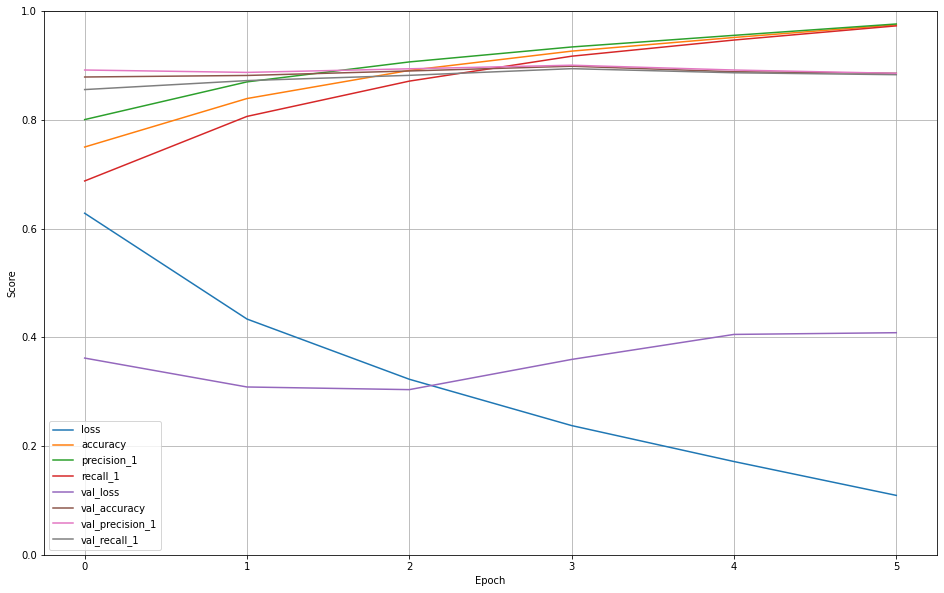

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def show_graph(history):
  pd.DataFrame(history.history).plot(figsize = (16, 10))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Score')
  plt.show()

show_graph(history)

In [ ]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [ ]:
encoded_labels_test = encode_labels(labels_test)

In [ ]:
reviews_processed_test = remove_digits(reviews_test)
unlabeled_processed_test = [] 

In [ ]:
#Use PyVi for Vietnamese word tokenizer
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [ ]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [ ]:
print('Shape of X train and X validation tensor:',data_test.shape)
print('Shape of label train and validation tensor:', labels_test.shape)

Shape of X train and X validation tensor: (1050, 100)
Shape of label train and validation tensor: (1050, 3)


In [ ]:
score = model.evaluate(data_test, labels_test)

33/33 [==============================] - 1s 28ms/step - loss: 1.1473 - accuracy: 0.6800 - precision_1: 0.6915 - recall_1: 0.6724


# Performance của Model

In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[2], score[2]*100))
print("%s: %.2f%%" % (model.metrics_names[3], score[3]*100))

loss: 114.73%
accuracy: 68.00%
precision_1: 69.15%
recall_1: 67.24%


In [ ]:
model.save_weights("/content/drive/MyDrive/Learning/Natural Language Processing/Exercises/Bai Tap Lon/LSTM/bilstm_attention.h5")

# Test model

In [ ]:
test = "Cuộc sống của bạn chỉ thật sự ý nghĩa và trọn vẹn khi bạn biết giữ gìn và nuôi dưỡng ước mơ, biết ghi nhận, biết tin vào những lời hứa"

reviews_processed_test = []

review_not_contain_digit = ''.join([char for char in test if char not in digits])
reviews_processed_test.append(review_not_contain_digit)

word_reviews_test = tokenize(reviews_processed_test)


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews_test)
sequences_train = tokenizer.texts_to_sequences(word_reviews_test)

sampleToPredit = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)

class_names = ["Negative", "Neutral", "Positive"]
pre = model.predict(sampleToPredit)
print(pre)
print(class_names[np.argmax(pre)])

[[0.52807534 0.42883852 0.0430862 ]]
Negative


In [ ]:
test = "Ôi tình xưa đã phai nay bàn tay nàng đan với ai Em giờ đây nỡ quên mối tình thơ ấu Thôi đành mang đớn đau cho người vui trọn đến kiếp sau Riêng mình tôi ôm lấy ngàn nỗi đau"

reviews_processed_test = []

review_not_contain_digit = ''.join([char for char in test if char not in digits])
reviews_processed_test.append(review_not_contain_digit)


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews_test)
sequences_train = tokenizer.texts_to_sequences(word_reviews_test)

sampleToPredit = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)

pre = model.predict(sampleToPredit)
print(pre)
print(class_names[np.argmax(pre)])

[[0.01578181 0.9655438  0.01867436]]
Neutral
